### Importing Important Libraries

#### Steps To Be Followed
1. Importing necessary Libraries
2. Creating S3 bucket 
3. Mapping train And Test Data in S3
4. Mapping The path of the models in S3

In [97]:
import sagemaker
import boto3  #  isused to read public s3 buckets 
from sagemaker.amazon.amazon_estimator import get_image_uri 
from sagemaker.session import s3_input, Session

In [98]:
bucket_name = 'churn-prediction321' # <--- CHANGE THIS VARIABLE TO A UNIQUE NAME FOR YOUR BUCKET
my_region = boto3.session.Session().region_name # set the region of the instance
print(my_region)

us-east-1


In [99]:
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


In [100]:
# set an output path where the trained model will be saved
prefix = 'xgboost-built-in'
output_path ='s3://{}/{}/output'.format(bucket_name, prefix)
print(output_path)

s3://churn-prediction321/xgboost-built-in/output


#### Downloading The Dataset And Storing in S3

In [101]:
import pandas as pd

try:
    model_data = pd.read_csv('./Churn Modeling.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: Data loaded into dataframe.


In [102]:
model_data

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [103]:
model_data.drop(columns=['CustomerId',"Surname"],inplace=True)
model_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9997,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9998,709,France,Female,36,7,0.00,1,0,1,42085.58,1


In [104]:
model_data['Gender'].replace({'Female':0,"Male":1},inplace=True)
model_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,0,42,2,0.00,1,1,1,101348.88,1
2,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
3,502,France,0,42,8,159660.80,3,1,0,113931.57,1
4,699,France,0,39,1,0.00,2,0,0,93826.63,0
5,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9996,771,France,1,39,5,0.00,2,1,0,96270.64,0
9997,516,France,1,35,10,57369.61,1,1,1,101699.77,0
9998,709,France,0,36,7,0.00,1,0,1,42085.58,1


In [105]:
df=pd.concat([model_data,pd.get_dummies(model_data['Geography'])],axis=1)
df=df.drop(columns=['Geography'])
df 

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
RowNumber,,,,,,,,,,,,,
1,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
2,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
3,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
4,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
5,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,771,1,39,5,0.00,2,1,0,96270.64,0,1,0,0
9997,516,1,35,10,57369.61,1,1,1,101699.77,0,1,0,0
9998,709,0,36,7,0.00,1,0,1,42085.58,1,1,0,0


In [106]:
### Train Test split

import numpy as np
train_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(7000, 13) (3000, 13)


In [107]:
train_data.insert(0, 'Exited', train_data.pop('Exited'))
test_data.insert(0, 'Exited', test_data.pop('Exited'))


In [108]:
train_data

,Exited,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
RowNumber,,,,,,,,,,,,,
5122,0,677,0,35,0,0.00,2,0,0,76637.38,0,0,1
3836,0,718,0,39,7,93148.74,2,1,1,190746.38,0,1,0
7664,0,590,1,39,9,0.00,2,1,1,104730.52,1,0,0
4537,0,642,0,55,7,0.00,2,1,1,101515.76,1,0,0
8263,0,737,0,33,4,0.00,2,1,0,115115.32,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9989,0,775,1,30,4,0.00,2,1,0,49337.84,1,0,0
5587,0,816,0,25,2,150355.35,2,1,1,35770.84,0,1,0
6026,0,601,0,46,3,98202.76,1,0,0,137763.93,1,0,0


In [109]:
test_data

,Exited,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
RowNumber,,,,,,,,,,,,,
8262,0,670,1,38,7,0.00,2,1,1,77864.41,1,0,0
2083,0,811,1,39,7,0.00,2,1,1,177519.39,0,0,1
1707,0,719,1,38,0,0.00,1,1,0,126876.47,0,0,1
6310,0,705,1,25,9,0.00,2,0,1,112331.19,1,0,0
4662,0,780,0,43,0,0.00,1,0,1,15705.27,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6030,1,659,0,44,9,23503.31,1,0,1,169862.01,1,0,0
5670,0,648,1,33,7,135310.41,2,0,1,171668.20,0,1,0
1268,0,837,1,38,2,126732.85,1,1,1,79577.38,0,1,0


In [110]:
# depndent feature should be first column 

train_data.to_csv('train.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)


In [111]:
### Saving Train And Test Into Buckets
## We start with Train Data
import os

# to upload train file from instance to s3 bucket 
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.TrainingInput(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

[02/11/25 12:54:04] INFO     Found credentials from IAM Role:                                   ]8;id=56422;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=371988;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [112]:
# Test Data Into Buckets
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_input_test = sagemaker.TrainingInput(s3_data='s3://{}/{}/test'.format(bucket_name, prefix), content_type='csv')

[02/11/25 12:54:05] INFO     Found credentials from IAM Role:                                   ]8;id=828874;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=446432;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

### Building Models Xgboot- Inbuilt Algorithm

In [113]:
# this line automatically looks for the XGBoost image URI and builds an XGBoost container.
# Retrieve the XGBoost container image URI
container = sagemaker.image_uris.retrieve(
    'xgboost',  # Algorithm or framework name
    boto3.Session().region_name,  # AWS region
    version='1.0-1'  # XGBoost version
)

print(container)

                    INFO     Defaulting to only available Python version: py3                     ]8;id=990712;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=230496;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#608\608]8;;\

                    INFO     Defaulting to only supported image scope: cpu.                       ]8;id=163549;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=201763;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#532\532]8;;\

683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


In [114]:
# initialize hyperparameters
# do not make hyperparamter tunnig in aws because of charge , do it locally 
hyperparameters = {
        "max_depth":"5",
        "eta":"0.2",
        "gamma":"4",
        "min_child_weight":"6",
        "subsample":"0.7",
        "objective":"binary:logistic",
        "num_round":50
        }

In [115]:
# construct a SageMaker estimator that calls the xgboost-container
estimator = sagemaker.estimator.Estimator(
                                            image_uri=container,
                                            hyperparameters=hyperparameters,
                                            role=sagemaker.get_execution_role(),
                                            instance_count=1,                # Updated parameter name
                                            instance_type='ml.m5.2xlarge',   # Updated parameter name
                                            volume_size=5,                   # Updated parameter name (in GB)
                                            output_path=output_path,
                                            use_spot_instances=True,         # Updated parameter name
                                            max_run=300,                     # Updated parameter name (in seconds)
                                            max_wait=600         
                                            )

In [116]:
estimator.fit({'train': s3_input_train,'validation': s3_input_test})

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=510793;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=827144;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=196194;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=847577;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             sagemaker-xgboost-2025-02-11-12-54-05-722                                             

2025-02-11 12:54:07 Starting - Starting the training job...
..25-02-11 12:54:22 Starting - Preparing the instances for training.
..25-02-11 12:54:59 Downloading - Downloading the training image.
..25-02-11 12:55:35 Training - Training image download completed. Training in progress..
2025-02-11 12:56:08 Uploading - Uploading generated training model
2025-02-11 12:56:08 Completed - Training job completed
[2025-02-11 12:55:52.728 ip-10-2-234-74.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determi

### Deploy Machine Learning Model As Endpoints

In [117]:
xgb_predictor = estimator.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

[02/11/25 12:56:22] INFO     Creating model with name: sagemaker-xgboost-2025-02-11-12-56-22-445    ]8;id=187048;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=87814;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[02/11/25 12:56:23] INFO     Creating endpoint-config with name                                     ]8;id=370925;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=892896;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5889\5889]8;;\
                             sagemaker-xgboost-2025-02-11-12-56-22-445                                             

                    INFO     Creating endpoint with name sagemaker-xgboost-2025-02-11-12-56-22-445  ]8;id=214084;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=47410;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4711\4711]8;;\

------!

#### Prediction of the Test Data

In [118]:
from sagemaker.serializers import CSVSerializer  # Correct import
import numpy as np

# Prepare the test data
test_data_array = test_data.drop(["Exited"], axis=1).values  # Load data into an array

# Set the data type and serializer for inference
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = CSVSerializer()  # Use CSVSerializer instead of csv_serializer

# Perform prediction and decode the result
predictions = xgb_predictor.predict(test_data_array).decode('utf-8')

# Convert the prediction string to a NumPy array
predictions_array = np.fromstring(predictions, sep=',')  # Adjust this line if necessary

# Print the shape of the predictions array
print(predictions_array.shape)


(3000,)


In [119]:
predictions_array

array([0.01530486, 0.00960919, 0.18688491, ..., 0.21892822, 0.03263786,
       0.05338488])

In [120]:
test_data['Exited'].value_counts()

0    2388
1     612
Name: Exited, dtype: int64

In [121]:
# np.round(predictions_array)
# test_data['Exited'].values

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2388
           1       0.72      0.45      0.56       612

    accuracy                           0.85      3000
   macro avg       0.80      0.70      0.74      3000
weighted avg       0.84      0.85      0.84      3000



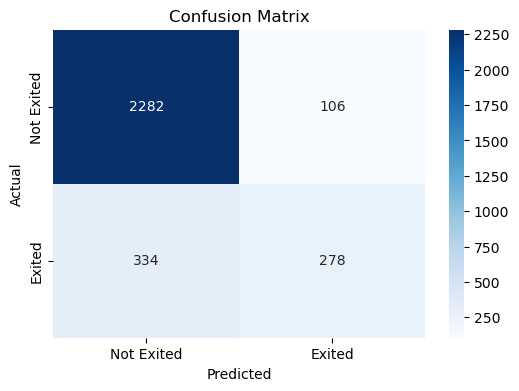

In [122]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# تقريب القيم المتوقعة
y_pred = np.round(predictions_array)

# القيم الحقيقية من test_data
y_true = test_data['Exited'].values

# طباعة تقرير التصنيف
print(classification_report(y_true, y_pred))

# رسم مصفوفة الارتباك
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Exited", "Exited"], yticklabels=["Not Exited", "Exited"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## making lambda handler

In [123]:
train_data.shape

(7000, 13)

In [134]:
endpoint_name=xgb_predictor.endpoint
print(f"endpoint name:{endpoint_name}")
runtime=boto3.client('runtime.sagemaker')
runtime


[02/13/25 12:19:21] WARNING  The endpoint attribute has been renamed in sagemaker>=2.            ]8;id=641908;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py\deprecations.py]8;;\:]8;id=42601;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/deprecations.py#34\34]8;;\
                             See: https://sagemaker.readthedocs.io/en/stable/v2.html for                           
                             details.                                                                              

endpoint name:sagemaker-xgboost-2025-02-11-12-56-22-445


In [126]:
test_data.head()

,Exited,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,France,Germany,Spain
RowNumber,,,,,,,,,,,,,
8262,0,670,1,38,7,0.0,2,1,1,77864.41,1,0,0
2083,0,811,1,39,7,0.0,2,1,1,177519.39,0,0,1
1707,0,719,1,38,0,0.0,1,1,0,126876.47,0,0,1
6310,0,705,1,25,9,0.0,2,0,1,112331.19,1,0,0
4662,0,780,0,43,0,0.0,1,0,1,15705.27,1,0,0


In [131]:
# sample_inputs=["CreditScore","Gender","Age","Tenure","Balance	NumOfProducts","HasCrCard","IsActiveMember","EstimatedSalary","France","Germany	Spain"]
test_array=np.array([670,1,38,7,0.0,2,1,1,77864.41,1,0,0])

In [132]:
def lambda_handler(event):
    inputs=event['data']
    serialized_input=",".join(map(str,inputs))
    response=runtime.invoke_endpoint(EndpointName=endpoint_name,ContentType='text/csv',Body=serialized_input)
    
    predictions_array=response['Body'].read().decode()
    return round(float(predictions_array))

# json_input={'data':test_array}

lambda_handler({"data":test_array})

0

## copy paste this in the lambda handler
**modify the endpoint name and configuration in aws lambda to make time out larger**

**give amazon sagemaker full access policy to aws lambda** 

In [133]:
!python --version 

Python 3.10.16


In [ ]:
# import boto3
# endpoint_name="sagemaker-xgboost-2025-02-07-06-27-59-668"  # change to your endpoint 
# runtime=boto3.client('runtime.sagemaker')
# def lambda_handler(event,context):
#     inputs=event['data']
#     serialized_input=",".join(map(str,inputs))
#     response=runtime.invoke_endpoint(EndpointName=endpoint_name,ContentType='text/csv',Body=serialized_input)
    
#     predictions_array=response['Body'].read().decode()
#     return predictions_array


#### Deleting The Endpoints and bucket  to avoid charges

In [ ]:
# sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
# bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
# bucket_to_delete.objects.all().delete()